In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/export.pkl
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/f481f76a6b75.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/abdb365cacbc.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/33ffddea8c6e.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/059bc89df7f4.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/278aa860dffd.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/d66b6f333dc7.png
/kaggle/i

In [2]:
# Necessary utility modules and libraries
import os
import shutil
import pathlib
import random
import datetime

# Plotting libraries 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Libraries for building the model
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPool2D, Dropout, GlobalAveragePooling2D, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.applications import DenseNet121, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import cohen_kappa_score

In [3]:
root_dir = '../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
classes = os.listdir(root_dir)
classes.pop(3)
classes

['Mild', 'Proliferate_DR', 'Moderate', 'No_DR', 'Severe']

In [4]:
# Walk through gaussian_filtered_images directory and list names of files
for dirpath, dirnames, filenames in os.walk(root_dir):
    print(f"There are {len(filenames)} images in {dirpath.split('/')[-1]}")

There are 1 images in gaussian_filtered_images
There are 370 images in Mild
There are 295 images in Proliferate_DR
There are 999 images in Moderate
There are 1805 images in No_DR
There are 193 images in Severe


In [5]:
# View random images in the dataset
def view_random_images(root_dir=root_dir, classes=classes):
    class_paths = [root_dir + "/" + image_class for image_class in classes]
    # print(class_paths)
    images_path = []
    labels = []
    for i in range(len(class_paths)):
        random_images = random.sample(os.listdir(class_paths[i]), 10)
        random_images_path = [class_paths[i]+'/'+img for img in random_images]
        for j in random_images_path:
            images_path.append(j)
            labels.append(classes[i])
    images_path

    plt.figure(figsize=(17, 10))
    plt.suptitle("Image Dataset", fontsize=20)

    for i in range(1, 51):
        plt.subplot(5, 10, i)
        img = mpimg.imread(images_path[i-1])
        plt.imshow(img, aspect="auto")
        plt.title(labels[i-1])
        plt.axis(False);

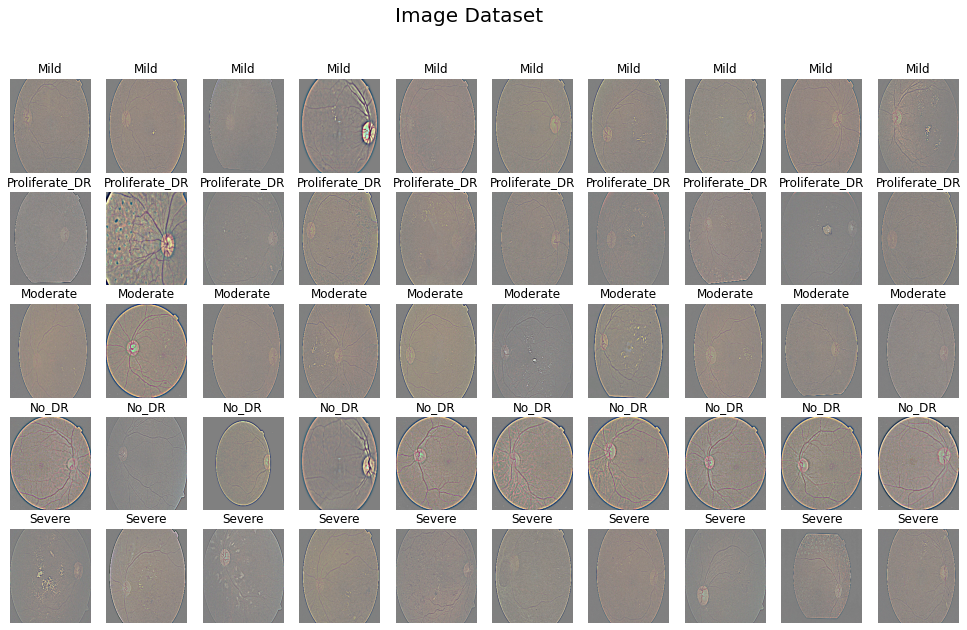

In [6]:
# Observing the images
view_random_images()

## Applying K-Fold cross validation on dataset

In [7]:
train_csv = pd.read_csv("../input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv")
train_csv

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


In [8]:
train_csv['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [9]:
train_df = {}
test_df = {}
for i in range(5):
    df = train_csv[train_csv['diagnosis']==i]['id_code'].to_list()
    for j in random.sample(df, int(0.8*len(df))):
        train_df[j] = i
    for j in df:
        if j not in train_df.keys():
            test_df[j] = i
train_df = pd.DataFrame(train_df.items(), columns=['id_code', 'diagnosis']).sample(frac=1, random_state=42)
test_df = pd.DataFrame(test_df.items(), columns=['id_code', 'diagnosis']).sample(frac=1, random_state=42)
train_df

,id_code,diagnosis
1472,5548a7961a3e,1
2178,d41b33fcb94f,2
368,b0f8613305a3,0
2614,0edadb2aa127,3
1818,40140a925c43,2
...,...,...
1638,e55188915f9d,1
1095,9e2058917304,0
1130,2a7373eeb352,0
1294,0cbcc7b23613,0


In [10]:
def mapping(df):
    class_code = {0: "No_DR",
                  1: "Mild", 
                  2: "Moderate",
                  3: "Severe",
                  4: "Proliferate_DR"}
    df['label'] = list(map(class_code.get, df['diagnosis']))
    df['path'] = [i[1]['label']+'/'+i[1]['id_code']+'.png' for i in df.iterrows()]
    return df

In [11]:
mapping(train_df), mapping(test_df)

(           id_code  diagnosis     label                       path
 1472  5548a7961a3e          1      Mild      Mild/5548a7961a3e.png
 2178  d41b33fcb94f          2  Moderate  Moderate/d41b33fcb94f.png
 368   b0f8613305a3          0     No_DR     No_DR/b0f8613305a3.png
 2614  0edadb2aa127          3    Severe    Severe/0edadb2aa127.png
 1818  40140a925c43          2  Moderate  Moderate/40140a925c43.png
 ...            ...        ...       ...                        ...
 1638  e55188915f9d          1      Mild      Mild/e55188915f9d.png
 1095  9e2058917304          0     No_DR     No_DR/9e2058917304.png
 1130  2a7373eeb352          0     No_DR     No_DR/2a7373eeb352.png
 1294  0cbcc7b23613          0     No_DR     No_DR/0cbcc7b23613.png
 860   b5bf7b84fc66          0     No_DR     No_DR/b5bf7b84fc66.png
 
 [2929 rows x 4 columns],
           id_code  diagnosis     label                       path
 666  c3a82acb7d7a          3    Severe    Severe/c3a82acb7d7a.png
 33   164cd5a3a6cd    

In [12]:
len(train_df), len(test_df)

(2929, 733)

In [13]:
# Initializing the input size
IMG_SHAPE = (224, 224)
N_SPLIT = 5
EPOCHS = 15

In [14]:
# Function to perform k-fold validation on test model
def validation_k_fold(model_test, k=5, epochs=EPOCHS, n_splits=N_SPLIT, lr=0.001): 
    kfold = StratifiedKFold(n_splits=N_SPLIT,shuffle=True,random_state=42)
    train_datagen = ImageDataGenerator(rescale = 1./255)
    validation_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen = ImageDataGenerator(rescale= 1./255)

    train_y = train_df['label']
    train_x = train_df['path']

    # Variable for keeping the count of the splits we're executing
    j = 0
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    for train_idx, val_idx in list(kfold.split(train_x,train_y)):
        x_train_df = train_df.iloc[train_idx]
        x_valid_df = train_df.iloc[val_idx]
        j+=1
        train_data = train_datagen.flow_from_dataframe(dataframe=x_train_df, 
                                                       directory=root_dir,
                                                       x_col='path',
                                                       y_col='label',
                                                       class_mode="categorical",
                                                       target_size=IMG_SHAPE)

        valid_data = validation_datagen.flow_from_dataframe(dataframe=x_valid_df, 
                                                           directory=root_dir,
                                                           x_col='path',
                                                           y_col='label',
                                                           class_mode="categorical",
                                                           target_size=IMG_SHAPE)
        
        test_data = test_datagen.flow_from_dataframe(dataframe=test_df, 
                                                   directory=root_dir,
                                                   x_col='path',
                                                   y_col='label',
                                                   class_mode="categorical",
                                                   target_size=IMG_SHAPE)
        
        # Initializing the early stopping callback
        es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        
        # Compile the model
        model_test.compile(loss='categorical_crossentropy',
                              optimizer=tf.keras.optimizers.Adamax(learning_rate=lr),
                              metrics=['accuracy'])
        history = model_test.fit_generator(train_data,
                                           validation_data=valid_data,
                                           epochs=epochs,
                                           validation_steps=len(valid_data),
                                           callbacks=[es])
        # Evaluate the model
        result = model_test.evaluate(test_data)
        model_test_result = {
            "test_loss": result[0],
            "test_accuracy": result[1],
        }
        y_pred = model_test.predict(test_data)
        return [history, model_test_result, y_pred, test_data.classes]

In [15]:
# Function to plot the performance metrics
def plot_result(hist):
    plt.figure(figsize=(10, 7));
    plt.suptitle(f"Performance Metrics", fontsize=20)
    
    # Actual and validation losses
    plt.subplot(2, 2, 1);
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.title('Train and validation loss curve')
    plt.legend()

    # Actual and validation accuracy
    plt.subplot(2, 2, 2);
    plt.plot(hist.history['accuracy'], label='train')
    plt.plot(hist.history['val_accuracy'], label='validation')
    plt.title('Training and validation accuracy curve')
    plt.legend()

## Modelling (base Models)
We'll use the following ImageNet models for training the images and observe the variations of the accuracy of the predicitions as predicted by the models:
* AlexNet
* VGG16
* CNN

## 1. AlexNet

In [16]:
# Basic CNN model for AlexNet
model_alexnet = tf.keras.Sequential([
    Conv2D(input_shape=IMG_SHAPE+(3,), filters=96,kernel_size=11,strides=4,activation='relu'),
    MaxPool2D(pool_size=3,strides=2),
    Conv2D(filters=256,kernel_size=5,strides=1,padding='valid',activation='relu'),
    MaxPool2D(pool_size=3,strides=2),
    Conv2D(filters=384,kernel_size=3,strides=1,padding='same',activation='relu'),
    Conv2D(filters=384,kernel_size=3,strides=1,padding='same',activation='relu'),
    Conv2D(filters=256,kernel_size=3,strides=1,padding='same',activation='relu'),
    MaxPool2D(pool_size=3,strides=2),
    Flatten(),
    Dense(len(classes), activation='softmax')
], name="model_AlexNet")

2022-08-28 23:44:17.140498: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 23:44:17.278073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 23:44:17.279058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 23:44:17.281006: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
# Summary of AlexNet model
# from tensorflow.keras.utils import plot_model
# plot_model(model_alexnet)
model_alexnet.summary()

Model: "model_AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 256)     

In [18]:
model_alexnet_history, model_alexnet_result, model_alexnet_pred, y_test = validation_k_fold(model_alexnet, lr=0.001)

Found 2343 validated image filenames belonging to 5 classes.
Found 586 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-08-28 23:44:22.128566: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-08-28 23:44:23.999404: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


74/74 [==============================] - 30s 304ms/step - loss: 1.3303 - accuracy: 0.4784 - val_loss: 1.2924 - val_accuracy: 0.4932
Epoch 2/15
74/74 [==============================] - 10s 132ms/step - loss: 1.2752 - accuracy: 0.4930 - val_loss: 1.0719 - val_accuracy: 0.4949
Epoch 3/15
74/74 [==============================] - 10s 135ms/step - loss: 0.9999 - accuracy: 0.6244 - val_loss: 0.9792 - val_accuracy: 0.6536
Epoch 4/15
74/74 [==============================] - 10s 133ms/step - loss: 0.9566 - accuracy: 0.6586 - val_loss: 0.9169 - val_accuracy: 0.6826
Epoch 5/15
74/74 [==============================] - 10s 136ms/step - loss: 0.9319 - accuracy: 0.6615 - val_loss: 0.8932 - val_accuracy: 0.6860
Epoch 6/15
74/74 [==============================] - 10s 130ms/step - loss: 0.9049 - accuracy: 0.6697 - val_loss: 0.8891 - val_accuracy: 0.6775
Epoch 7/15
74/74 [==============================] - 10s 134ms/step - loss: 0.8590 - accuracy: 0.6761 - val_loss: 0.8416 - val_accuracy: 0.6911
Epoch 8/15

In [19]:
# Evaluation metrics for alexnet
model_alexnet_result

{'test_loss': 0.8164005875587463, 'test_accuracy': 0.698499321937561}

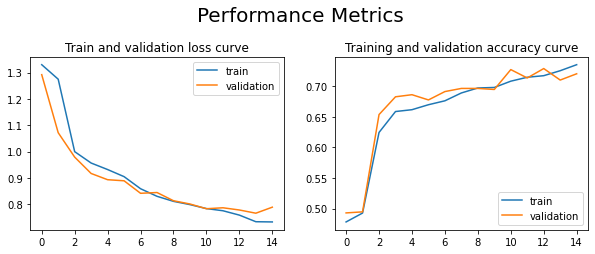

In [20]:
# Performance metrics for AlexNet
plot_result(model_alexnet_history)

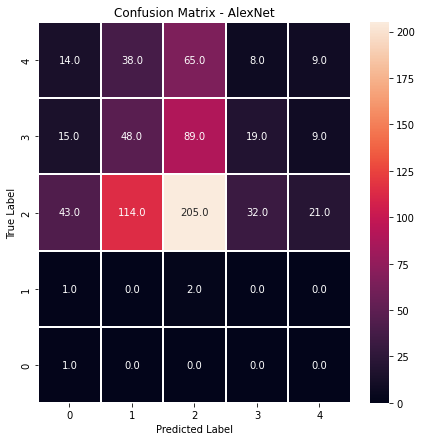

In [21]:
y_pred_alexnet = np.argmax(model_alexnet_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred_alexnet, y_test)
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
patient_labels = ['4', '3', '2', '1', '0']
ax.yaxis.set_ticklabels(patient_labels)
plt.title("Confusion Matrix - AlexNet")
plt.show()

In [22]:
print(classification_report(y_test, y_pred_alexnet))

              precision    recall  f1-score   support

           0       0.10      0.19      0.13        74
           1       0.27      0.24      0.25       200
           2       0.49      0.57      0.53       361
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00        39

    accuracy                           0.36       733
   macro avg       0.17      0.20      0.18       733
weighted avg       0.33      0.36      0.34       733



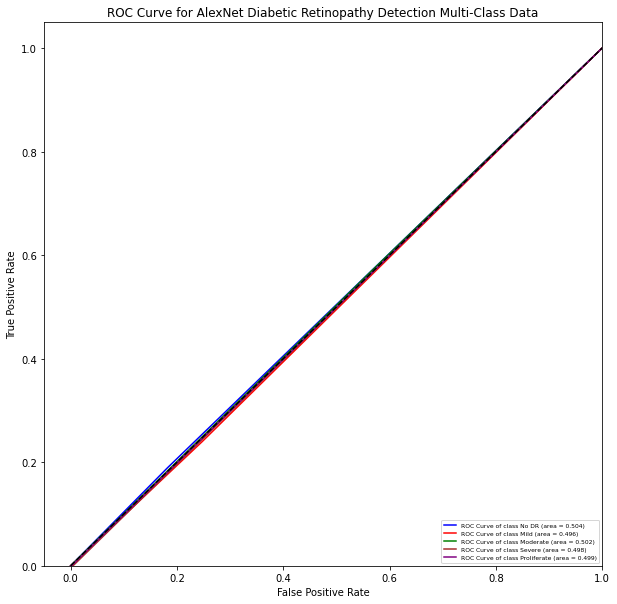

In [23]:
class_labels = ['No DR','Mild','Moderate','Severe','Proliferate']
y_score = label_binarize(y_pred_alexnet, classes = [0,1,2,3,4])
ytest_binary = label_binarize(y_test, classes = [0,1,2,3,4]) # one hot encode the test data true labels
n_classes = y_score.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict() 
# compute fpr and tpr with roc_curve from the ytest true labels to the scores
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest_binary[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot each class  curve on single graph for multi-class one vs all classification
f,ax = plt.subplots(figsize=(10, 10))
colors = ['blue', 'red', 'green', 'brown', 'purple']
for i, color, lbl in zip(range(n_classes), colors, class_labels):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw = 1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for AlexNet Diabetic Retinopathy Detection Multi-Class Data')
plt.legend(loc = 'lower right', prop = {'size': 6})
plt.show()

## 2. VGG16

In [24]:
# Basic CNN model for VGG16
model_vgg16 = tf.keras.Sequential([
    Conv2D(input_shape=IMG_SHAPE+(3,), filters=64,kernel_size=3,strides=4,activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPool2D(2, strides=2, padding='same'),
    Conv2D(28, 3, padding='same', activation='relu'),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPool2D(2, strides=2, padding='same'),
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPool2D(2, strides=2, padding='same'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    MaxPool2D(2, strides=2, padding='same'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    MaxPool2D(2, strides=2, padding='same'),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(len(classes), activation='softmax')
], name="model_vgg16")

In [25]:
# Summary of vgg16 model
model_vgg16.summary()
model_vgg16_history, model_vgg16_result, model_vgg16_pred, y_test = validation_k_fold(model_vgg16, lr=0.0001)

Model: "model_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 56, 56, 64)        1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 28)        16156     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 128)       32384     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 256)       

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
74/74 [==============================] - 12s 150ms/step - loss: 1.2908 - accuracy: 0.4878 - val_loss: 1.1807 - val_accuracy: 0.4932
Epoch 2/15
74/74 [==============================] - 10s 129ms/step - loss: 1.1208 - accuracy: 0.4930 - val_loss: 1.0253 - val_accuracy: 0.4932
Epoch 3/15
74/74 [==============================] - 10s 134ms/step - loss: 1.0470 - accuracy: 0.5216 - val_loss: 1.0028 - val_accuracy: 0.6826
Epoch 4/15
74/74 [==============================] - 10s 137ms/step - loss: 0.9870 - accuracy: 0.6304 - val_loss: 0.9054 - val_accuracy: 0.6826
Epoch 5/15
74/74 [==============================] - 10s 131ms/step - loss: 0.9001 - accuracy: 0.6731 - val_loss: 0.8467 - val_accuracy: 0.6911
Epoch 6/15
74/74 [==============================] - 10s 133ms/step - loss: 0.8709 - accuracy: 0.6850 - val_loss: 0.8250 - val_accuracy: 0.6928
Epoch 7/15
74/74 [==============================] - 10s 139ms/step - loss: 0.8475 - accuracy: 0.6923 - val_loss: 0.8100 - val_accuracy: 0.6997

In [26]:
# Evaluation metrics for alexnet
model_vgg16_result

{'test_loss': 0.8106656074523926, 'test_accuracy': 0.7285129427909851}

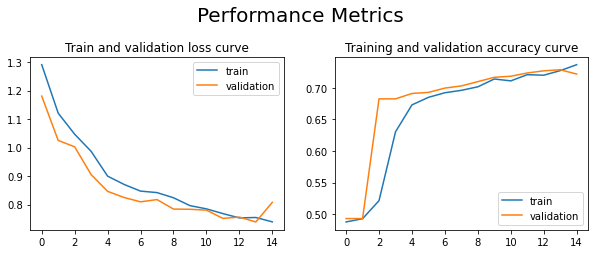

In [27]:
# Performance metrics for AlexNet
plot_result(model_vgg16_history)

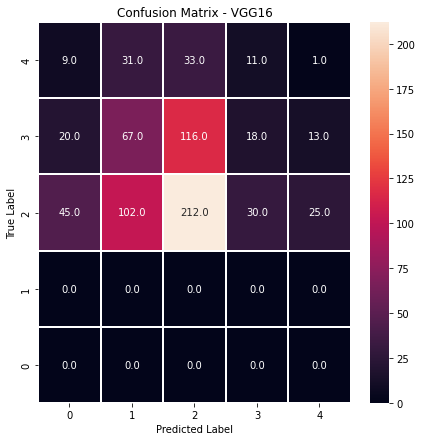

In [28]:
y_pred_vgg16 = np.argmax(model_vgg16_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred_vgg16, y_test)
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
patient_labels = ['4', '3', '2', '1', '0']
ax.yaxis.set_ticklabels(patient_labels)
plt.title("Confusion Matrix - VGG16")
plt.show()

In [29]:
print(classification_report(y_test, y_pred_vgg16))

              precision    recall  f1-score   support

           0       0.11      0.12      0.11        74
           1       0.29      0.34      0.31       200
           2       0.51      0.59      0.55       361
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00        39

    accuracy                           0.39       733
   macro avg       0.18      0.21      0.19       733
weighted avg       0.34      0.39      0.37       733



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


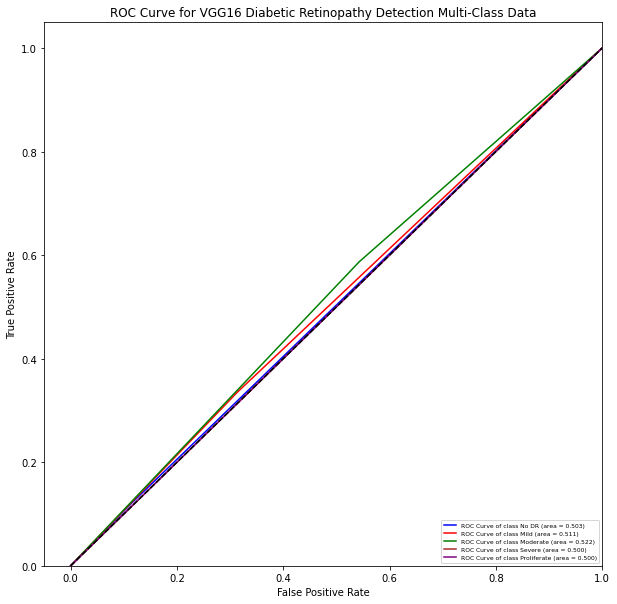

In [30]:
class_labels = ['No DR','Mild','Moderate','Severe','Proliferate']
y_score = label_binarize(y_pred_vgg16, classes = [0,1,2,3,4])
ytest_binary = label_binarize(y_test, classes = [0,1,2,3,4]) # one hot encode the test data true labels
n_classes = y_score.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict() 
# compute fpr and tpr with roc_curve from the ytest true labels to the scores
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest_binary[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot each class  curve on single graph for multi-class one vs all classification
f,ax = plt.subplots(figsize=(10, 10))
colors = ['blue', 'red', 'green', 'brown', 'purple']
for i, color, lbl in zip(range(n_classes), colors, class_labels):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw = 1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for VGG16 Diabetic Retinopathy Detection Multi-Class Data')
plt.legend(loc = 'lower right', prop = {'size': 6})
plt.show()

## CNN

In [31]:
# Basic CNN model for VGG16
model_cnn = tf.keras.Sequential([
    Conv2D(input_shape=IMG_SHAPE+(3,), filters=8,kernel_size=3,strides=4,activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    BatchNormalization(),
      
    Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    MaxPool2D(pool_size=(2,2)),
    BatchNormalization(),
    
    Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    MaxPool2D(pool_size=(2,2)),
    BatchNormalization(),
 
    Flatten(),
    Dense(32, activation = 'relu'),
    Dropout(0.15),
    Dense(len(classes), activation = 'softmax')
], name="model_cnn")

In [32]:
# Summary of cnn model
model_cnn.summary()
model_cnn_history, model_cnn_result, model_cnn_pred, y_test = validation_k_fold(model_cnn, lr=0.001)

Model: "model_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 56, 56, 8)         224       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 8)         32        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 26, 26, 16)        1168      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 16)        64        
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 10, 10, 32)        82

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
74/74 [==============================] - 11s 130ms/step - loss: 0.9462 - accuracy: 0.6526 - val_loss: 1.4477 - val_accuracy: 0.5290
Epoch 2/15
74/74 [==============================] - 10s 133ms/step - loss: 0.7399 - accuracy: 0.7341 - val_loss: 1.3036 - val_accuracy: 0.4983
Epoch 3/15
74/74 [==============================] - 10s 129ms/step - loss: 0.6967 - accuracy: 0.7388 - val_loss: 1.2472 - val_accuracy: 0.4932
Epoch 4/15
74/74 [==============================] - 9s 126ms/step - loss: 0.6295 - accuracy: 0.7691 - val_loss: 1.2171 - val_accuracy: 0.4932
Epoch 5/15
74/74 [==============================] - 10s 137ms/step - loss: 0.5896 - accuracy: 0.7896 - val_loss: 1.0659 - val_accuracy: 0.5256
Epoch 6/15
74/74 [==============================] - 10s 130ms/step - loss: 0.5544 - accuracy: 0.7883 - val_loss: 1.1418 - val_accuracy: 0.5410
Epoch 7/15
74/74 [==============================] - 9s 125ms/step - loss: 0.5225 - accuracy: 0.8101 - val_loss: 0.9478 - val_accuracy: 0.6706
E

In [33]:
# Evaluation metrics for alexnet
model_cnn_result

{'test_loss': 0.8035586476325989, 'test_accuracy': 0.7094133496284485}

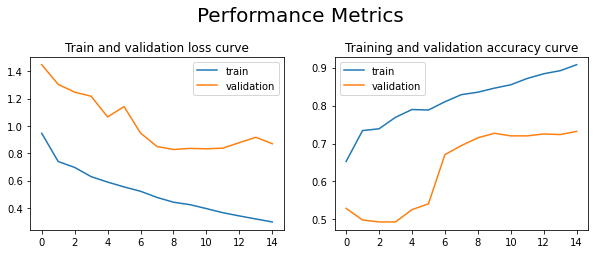

In [34]:
# Performance metrics for AlexNet
plot_result(model_cnn_history)

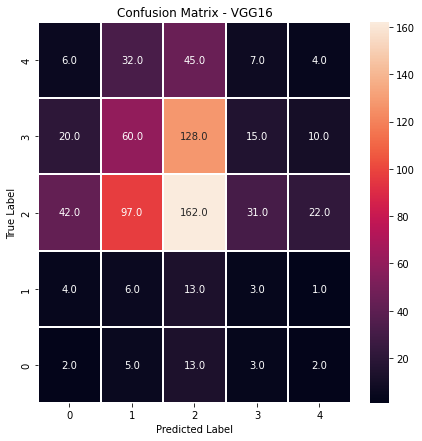

In [35]:
y_pred_cnn = np.argmax(model_cnn_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred_cnn, y_test)
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
patient_labels = ['4', '3', '2', '1', '0']
ax.yaxis.set_ticklabels(patient_labels)
plt.title("Confusion Matrix - VGG16")
plt.show()

In [36]:
print(classification_report(y_test, y_pred_cnn))

              precision    recall  f1-score   support

           0       0.06      0.08      0.07        74
           1       0.26      0.30      0.28       200
           2       0.46      0.45      0.45       361
           3       0.11      0.05      0.07        59
           4       0.08      0.05      0.06        39

    accuracy                           0.32       733
   macro avg       0.19      0.19      0.19       733
weighted avg       0.32      0.32      0.31       733



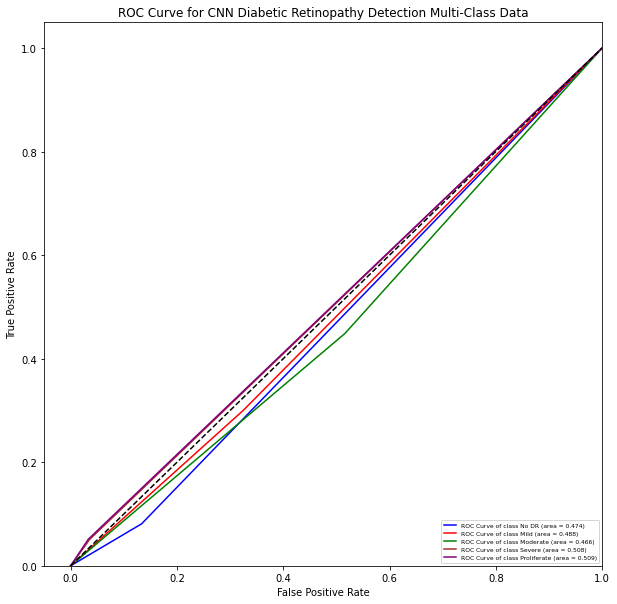

In [37]:
class_labels = ['No DR','Mild','Moderate','Severe','Proliferate']
y_score = label_binarize(y_pred_cnn, classes = [0,1,2,3,4])
ytest_binary = label_binarize(y_test, classes = [0,1,2,3,4]) # one hot encode the test data true labels
n_classes = y_score.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict() 
# compute fpr and tpr with roc_curve from the ytest true labels to the scores
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest_binary[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot each class  curve on single graph for multi-class one vs all classification
f,ax = plt.subplots(figsize=(10, 10))
colors = ['blue', 'red', 'green', 'brown', 'purple']
for i, color, lbl in zip(range(n_classes), colors, class_labels):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw = 1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN Diabetic Retinopathy Detection Multi-Class Data')
plt.legend(loc = 'lower right', prop = {'size': 6})
plt.show()

## Visualizing the predictions of all the base models

In [38]:
def pred_vals(model_history):
    d = {}
    d['acc'] = np.mean(model_history.history['accuracy'])
    d['val_acc'] = np.mean(model_history.history['val_accuracy'])
    return d    

In [39]:
df_result = pd.DataFrame({'AlexNet': pred_vals(model_alexnet_history),
                           'VGG16': pred_vals(model_vgg16_history),
                           'CNN': pred_vals(model_cnn_history)}).transpose()
df_result = df_result.reset_index().rename(columns={'index': 'model'})
df_result

,model,acc,val_acc
0,AlexNet,0.662996,0.670990
1,VGG16,0.660720,0.678953
2,CNN,0.813515,0.633902


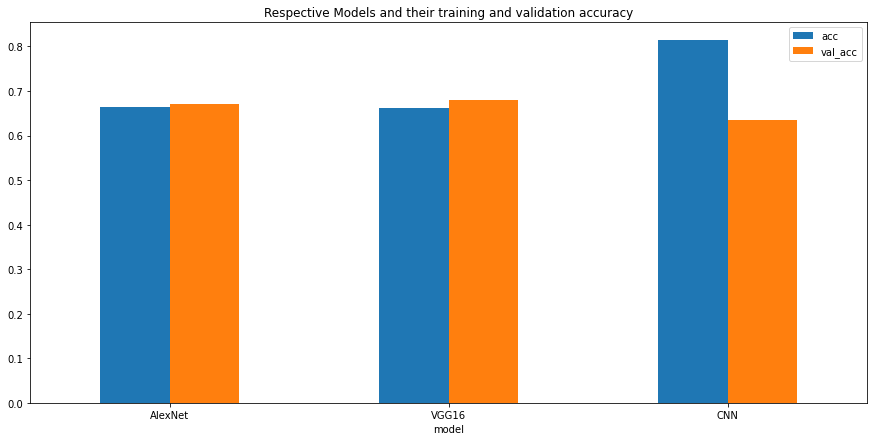

In [40]:
# plt.style.use('seaborn')
# Plotting models and their accuracy performance
df_result.plot(x='model', y=['acc', 'val_acc'], kind='bar', figsize=(15, 7))
plt.xticks(rotation=0)
plt.title('Respective Models and their training and validation accuracy');

## Plotting predictions on Test Dataset

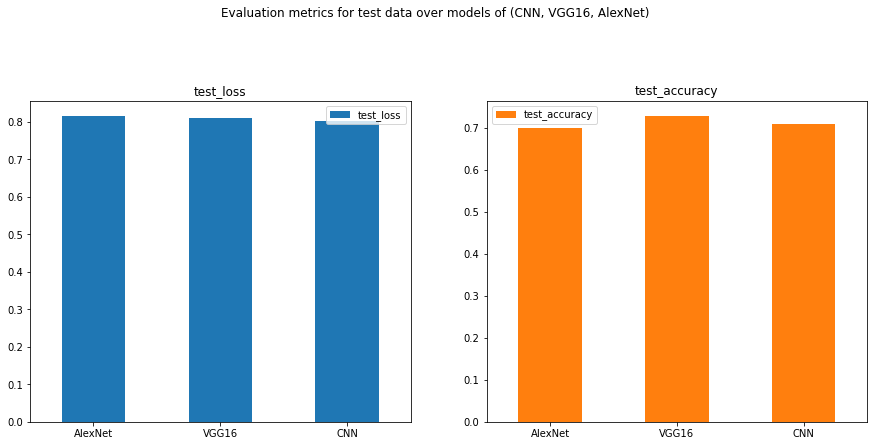

In [41]:
# Test results dataframe
test_results = pd.DataFrame([model_alexnet_result,model_vgg16_result,model_cnn_result], index=["AlexNet", "VGG16", "CNN"])
test_results.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 13), rot=0, title="Evaluation metrics for test data over models of (CNN, VGG16, AlexNet)");